In [93]:
import tensorflow as tf
import numpy as np

import os
import sys
import time
import random
import math
import numpy as np
#import skimage.io
import imageio
import cv2
import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy.io as sio

import visualize

%matplotlib inline

In [156]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# video directory
video_dir = "../../../../aic2018/track1/track1_videos/"
detect_dir = "../../../../aic2018/track1/detect/"
save_dir = "../../../../aic2018/track1/detect_videos/"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
# read transform matrix
M = sio.loadmat('track1_M.mat')
keys = list(M.keys())
for k in keys:
    if not k.startswith('M'):
        M.pop(k, None)
# match videos and M matrices
videos = sorted([(i, x) for i, x in enumerate(sorted(os.listdir(video_dir))) if x.endswith('.mp4')])
Ms = dict()
for k in M.keys():
    m = M[k]
    t = k.replace('M', '').split('_')
    if len(t) == 1:
        s, e = t[0], t[0]
    else:
        s, e = t
    s, e = int(s), int(e)
    for i in range(s, e+1):
        Ms[videos[i][1]] = m

/Users/tingyumao/Programs/anaconda3/envs/dlenv/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Loc2_3.mp4
Processing video Loc2_3.mp4...


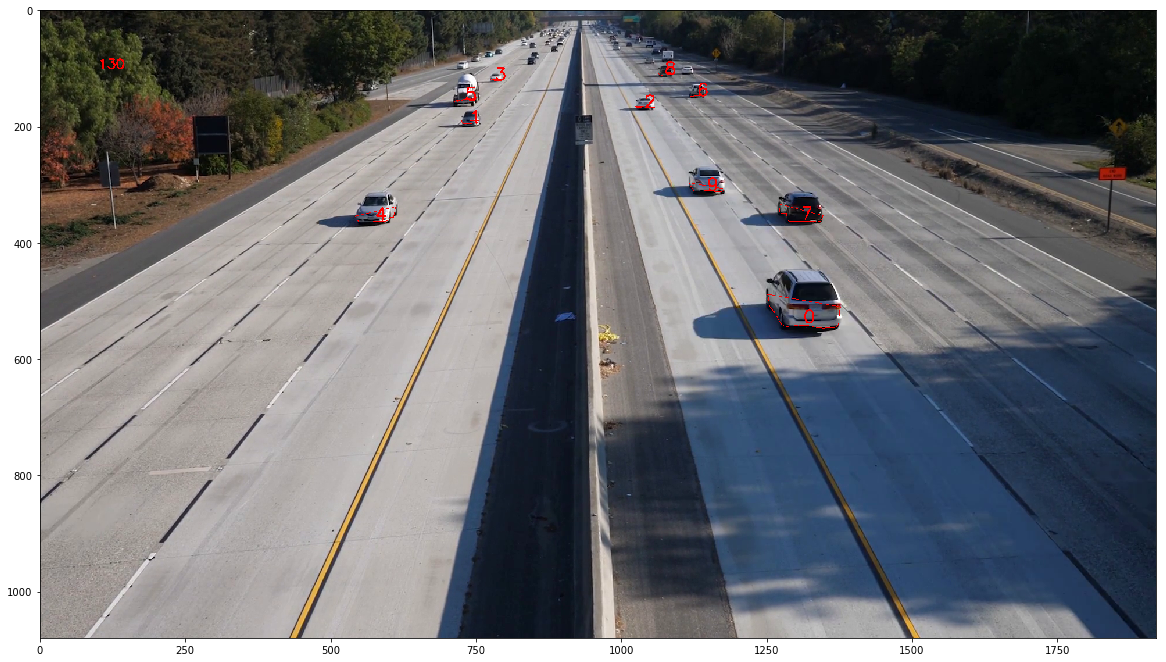

In [157]:
# set upper and lower bound of visualizd frames
def savefig(x):
    x = 130 # show_fnum
    fnum = x
    videoname = [x for x in os.listdir(video_dir) if x.startswith("Loc2_3")][0]
    print(videoname)
    print("Processing video {}...".format(videoname))
    # read video
    video_file = os.path.join(video_dir, videoname)
    vid = imageio.get_reader(video_file,  'ffmpeg')
    # load pkl files
    pkl_dir = os.path.join(detect_dir, videoname)
    pkl_file = str(x).zfill(7)+".pkl"#sorted([x for x in os.listdir(pkl_dir)])
    r = pickle.load(open(os.path.join(pkl_dir,pkl_file), "rb"))
    mask_image = visualize.draw_contours(vid.get_data(fnum), r['rois'], r['contours'], 
                                         r['class_ids'],class_names, r['scores'])
    bottom_contour = [visualize.extract_bottom(c) for i, c in enumerate(r['contours']) 
                      if class_names[r['class_ids'][i]] in ['car', 'motorcycle', 'bus', 'train', 'truck']]

    cv2.putText(mask_image, str(fnum), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 0.75, 255, 2)
    cnt = 0
    for bc in bottom_contour:
        for c in bc:
            if c.shape[0] > 1:
                c = np.squeeze(c)
            else:
                c = c[0]
            cv2.putText(mask_image, str(cnt), (int(np.mean(c[:,0])),int(np.mean(c[:,1]))), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
            cnt += 1

    # visualize mask_image
    plt.figure(figsize=(20,40))
    plt.imshow(mask_image)
    # 2d to 3d
    def coord2dto3d(m, pts):
        """
        m: [3,3]
        pts: [n, 3]
        """
        X = pts # (u,v,1)
        N = 2
        U1 = np.dot(X, m) # transform in homogeneous coordinates
        UN = np.tile(U1[:, -1][:,np.newaxis], (1, N)) # replicate the last column of U
        U = U1[:, :-1] / UN
        return U

    m = Ms[videoname]
    pt3d = []
    for i, objc in enumerate(bottom_contour):
        for c in objc:
            if c.shape[0] > 1:
                c = np.squeeze(c)
            else:
                c = c[0]
            c = np.concatenate((c, np.ones((c.shape[0], 1))), axis=1)
            c3d = coord2dto3d(m, c)
            pt3d.append(c3d)

    pt3d_np = np.concatenate(pt3d, axis=0)

    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(pt3d_np[:, 0], pt3d_np[:, 1])
    """
    for i, pts in enumerate(pt3d):
        #ax.annotate(str(i), (np.mean(pts[:,0]), np.mean(pts[:,1])))
        if i == 14:
            ax.scatter(pts[:, 0], pts[:, 1], color='red')
        ax.text(int(np.mean(pts[:,0])), int(np.mean(pts[:,1])), str(i), fontsize=40)
    """
    plt.axis('equal')
    plt.savefig("test.png")
    plt.close(fig) 
    
savefig(30)

In [167]:
# write output video
fps = 30 #vid.get_meta_data()['fps']
writer = imageio.get_writer('test3d.mp4', fps=fps)
save_dir = 'save'
for img in sorted(os.listdir(save_dir)):
    if img.endswith('png'):
        print(img)
        writer.append_data(cv2.imread(os.path.join(save_dir, img)))
writer.close()

0000000.png
0000001.png
0000002.png
0000003.png
0000004.png
0000005.png
0000006.png
0000007.png
0000008.png
0000009.png
0000010.png
0000011.png
0000012.png
0000013.png
0000014.png
0000015.png
0000016.png
0000017.png
0000018.png
0000019.png
0000020.png
0000021.png
0000022.png
0000023.png
0000024.png
0000025.png
0000026.png
0000027.png
0000028.png
0000029.png
0000030.png
0000031.png
0000032.png
0000033.png
0000034.png
0000035.png
0000036.png
0000037.png
0000038.png
0000039.png
0000040.png
0000041.png
0000042.png
0000043.png
0000044.png
0000045.png
0000046.png
0000047.png
0000048.png
0000049.png
0000050.png
0000051.png
0000052.png
0000053.png
0000054.png
0000055.png
0000056.png
0000057.png
0000058.png
0000059.png
0000060.png
0000061.png
0000062.png
0000063.png
0000064.png
0000065.png
0000066.png
0000067.png
0000068.png
0000069.png
0000070.png
0000071.png
0000072.png
0000073.png
0000074.png
0000075.png
0000076.png
0000077.png
0000078.png
0000079.png
0000080.png
0000081.png
0000082.png
0000